In [25]:
import numpy as np
import operator
import csv

Reading datasets.

In [26]:
def read_spam():
    D = []
    
    with open('./Datasets/spam.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array([np.array(row[:-1]), row[-1]]))

    return np.array(D)

In [27]:
def read_cancer():
    D = []
    
    with open('./Datasets/cancer.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            D.append(np.array([np.array(list(map(float, row[1:]))), row[0]]))

    return np.array(D)

In [28]:
def read_blobs():
    D = []
    
    with open('./Datasets/blobs.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array(row))

    return np.array(D)

kNN

Datasets are spam.csv and cancer.csv.

1. (8 points) Implement the kNN algorithm and calculate Leave-one-out error on both datasets for 1 to 10 neighbors.

Hint. You can find the 10 nearest neighbors and then crop it to 9, 8 and so on.

In [29]:
import heapq

def k_neighbors(x, D, k):
    def dist(row):
        return np.linalg.norm(row[0] - x)
    return heapq.nsmallest(k, D, dist)

In [30]:
def kNN(x, D, k, neighbors=None):
    if neighbors is None:
        neighbors = k_neighbors(x, D, k)
    
    label_cnt = dict()
    for value in neighbors:
        label_cnt[value[1]] = label_cnt.get(value[1], 0) + 1
    
    h = max(label_cnt.items(), key=operator.itemgetter(1))[0]
    return h

In [31]:
def LOO(D, K):
    res = np.zeros(K)
    
    for i, row in enumerate(D):
        Di = np.delete(D, i, 0)
        neighbors = k_neighbors(row[0], Di, K)
        for k in range(1, K + 1):
            res[k - 1] += 1 if kNN(row[0], Di, k, neighbors[:k]) != row[1] else 0
    
    res /= len(D)
    return res

In [58]:
K = 10
D = read_spam()
res = LOO(D, K)
print('Leave-one-out error for spam dataset:')
print(res)

Leave-one-out error for spam dataset:
[ 0.16952836  0.19061074  0.18517714  0.19278418  0.18582917  0.20039122
  0.19582699  0.20104325  0.202782    0.20212997]


In [62]:
K = 10
D = read_cancer()
res = LOO(D, K)
print('Leave-one-out error for cancer dataset:')
print(res)

Leave-one-out error for cancer dataset:
[ 0.08435852  0.07732865  0.07381371  0.07381371  0.06678383  0.07029877
  0.0685413   0.07029877  0.06678383  0.07029877]


2. (2) Scale all features with MinMax scaler to [0,1] and calculate Leave-one-out error on both datasets for 1 to 10 neighbors.

In [32]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale(D):
    scaler = MinMaxScaler()
    features = np.array([row[0] for row in D])
    scaled_features = scaler.fit_transform(features)
    scaled_D = np.copy(D)
    for i in range(len(D)):
        scaled_D[i][0] = scaled_features[i]

    return scaled_D

In [12]:
K = 10
D = read_spam()
res = LOO(min_max_scale(D), K)
print('Leave-one-out error for scaled spam dataset:')
print(res)

Leave-one-out error for scaled spam dataset:
[0.087807   0.087807   0.09476201 0.08911106 0.0951967  0.08911106
 0.09932623 0.09063247 0.10193436 0.09693545]


In [10]:
K = 10
D = read_cancer()
res = LOO(min_max_scale(D), K)
print('Leave-one-out error for scaled cancer dataset:')
print(res)

Leave-one-out error for scaled cancer dataset:
[0.04745167 0.04745167 0.02987698 0.02811951 0.03339192 0.03163445
 0.02987698 0.02987698 0.02987698 0.02636204]


Clustering

Dataset is blobs.csv.

The results should be presented as drawn clusters.

3. (2) Implement the k-means algorithm and cluster data point into [2,3,4,5] clusters.

In [90]:
import random

In [91]:
def kMeans(D, k):
    clusters_idx = list(range(k))
    centers = random.sample(list(D), k)
    
    while True:
        def dist_to_x(x):
            return lambda idx: np.linalg.norm(x - centers[idx])
   
        clusters = [min(clusters_idx, key=dist_to_x(x)) for x in D]
        clusters_cnt = np.zeros(len(D))
        old_centers = np.copy(centers)
        
        for i in range(len(D)):
            centers[clusters[i]] = np.array(centers[clusters[i]]) + D[i]
            clusters_cnt[clusters[i]] += 1
        
        for i in range(k):
            if clusters_cnt[i] != 0:
                centers[i] /= clusters_cnt[i]
            
        if np.allclose(old_centers, centers):
            break
        
    return np.array(clusters) + 1

In [92]:
import matplotlib.pyplot as plt

colors = ['black', 'blue', 'red', 'green', 'yellow', 'magenta']


def plot_clusters(D, clusters):
    x = [row[0] for row in D]
    y = [row[1] for row in D]
    c = [colors[i % 6] for i in clusters]
    
    plt.scatter(x, y, c=c)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

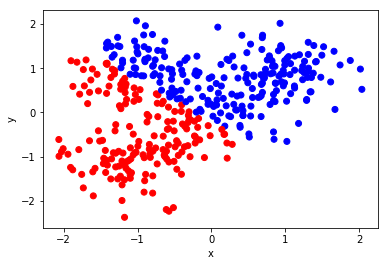

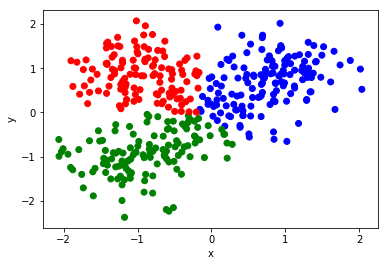

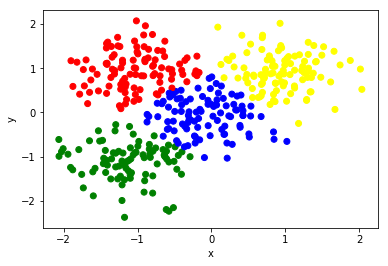

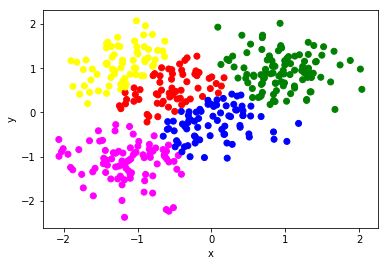

In [94]:
D = read_blobs()

for k in range(2, 6):
    clusters = kMeans(D, k)
    plot_clusters(D, clusters)

4. (2) Implement the DBSCAN algorithm and find parameters for clustering into [2,3,4,5] clusters.

In [50]:
def DBSCAN(D, m, eps):
    dataset_range = range(len(D))
    clusters_cnt = 0
    clusters = np.zeros(len(D), dtype=int)
    
    for i in dataset_range:
        if clusters[i] != 0:
            continue
            
        neighbors = []
        for j in dataset_range:
            if i != j and np.linalg.norm(D[i] - D[j]) < eps:
                neighbors.append(j)

        if len(neighbors) < m:
            continue
        
        clusters_cnt += 1
        clusters[i] = clusters_cnt
        
        while True:
            next_neighbors = []
            
            for j in neighbors:
                if clusters[j] != 0:
                    continue
                
                clusters[j] = clusters_cnt
                
                current_neighbors = []
                for k in dataset_range:
                    if j != k and np.linalg.norm(D[j] - D[k]) < eps:
                        current_neighbors.append(k)
        
                if len(current_neighbors) >= m:
                    next_neighbors.extend(current_neighbors)
 
            if len(next_neighbors) == 0:
                break
                
            neighbors = np.copy(next_neighbors)
        
    return np.array(clusters)

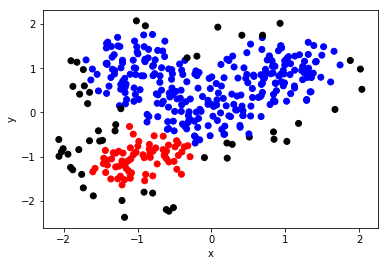

In [58]:
D = read_blobs()
clusters = DBSCAN(D, 40, 0.5)
plot_clusters(D, clusters)

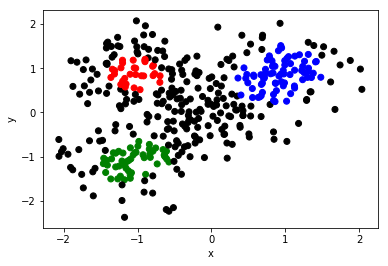

In [103]:
D = read_blobs()
clusters = DBSCAN(D, 30, 0.38)
plot_clusters(D, clusters)

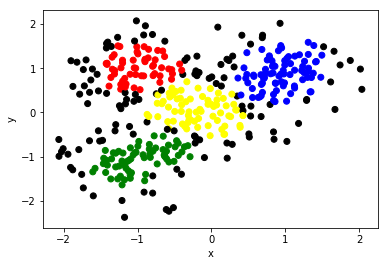

In [79]:
D = read_blobs()
clusters = DBSCAN(D, 30, 0.4)
plot_clusters(D, clusters)

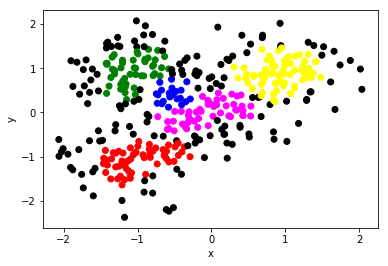

In [149]:
D = read_blobs()
clusters = DBSCAN(D, 12, 0.25)
plot_clusters(D, clusters)

5. (3) Implement the Agglomerative Clustering and output the clustering into [2,3,4,5] clusters.

In [183]:
def dist_btw_clusters(D, a, b):
    return max([np.linalg.norm(D[i] - D[j]) for i in a for j in b])

def agglomerative_clustering(D, k):
    clusters = list([[i] for i in range(len(D))])
    distances = np.zeros(len(D))
    
    while len(clusters) > k:
        merge_idx = []
        merge_min_dist = None
        
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                new_distances = np.delete(distances, [i, j], 0)
                merge_dist = max([dist_btw_clusters(D, clusters[i], clusters[j]), distances[i], distances[j]])               
                new_distances = np.append(new_distances, merge_dist)
                merge_cur_dist = max(new_distances)
                
                if merge_min_dist is None or merge_cur_dist < merge_min_dist:
                    merge_min_dist = merge_cur_dist
                    merge_idx = [i, j]

        distances = np.delete(distances, merge_idx, 0)
        distances = np.append(distances, merge_min_dist)
        clusters.append(np.append(clusters[merge_idx[0]], clusters[merge_idx[1]]))
        clusters = np.delete(np.array(clusters), merge_idx, 0)
        clusters = clusters.tolist()
        
    ans = np.zeros(len(D), dtype=int)
    for i in range(len(clusters)):
        for j in clusters[i]:
            ans[j] = i
            
    return ans

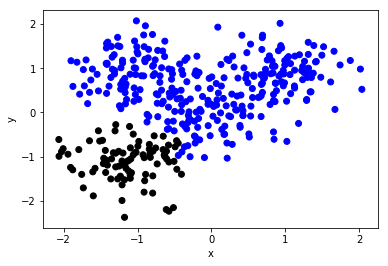

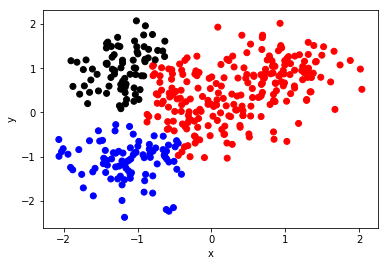

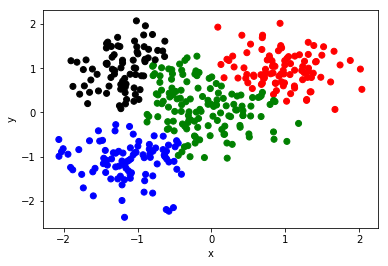

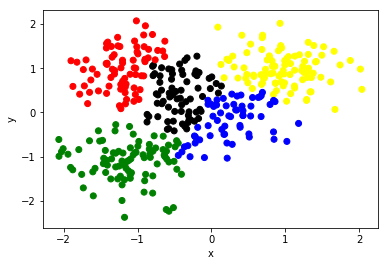

In [186]:
D = read_blobs()

for k in range(2, 6):
    clusters = agglomerative_clustering(D, k)
    plot_clusters(D, clusters)

Dataset is cancer.csv.

6. (2) Cluster datapoints into [2,3,5,10] clusters with k-Means and calculate the Purity metric.


In [95]:
def purity(D, clusters, k):
    Y = np.array([row[1] for row in D])
    ans = 0
    
    for i in range(1, k + 1):
        cnt = dict()
        for y in Y[clusters == i]:
            cnt[y] = cnt.get(y, 0) + 1
        if len(cnt) != 0:
            ans += max(cnt.items(), key=operator.itemgetter(1))[1]
        
    ans /= len(D)
    return ans

In [96]:
D = read_cancer()
X = [row[0] for row in D]

for k in [2, 3, 5, 10]:
    clusters = kMeans(X, k)
    print(purity(D, clusters, k))

0.8506151142355008
0.8875219683655536
0.8822495606326889
0.8822495606326889


Rules and curves

Datasets are spam.csv and cancer.csv.

7. (2) Calculate ROC-AUC for threshold rules for every feature for both datasets. Draw ROC curves for the best three in both.


Validation

Datasets are spam.csv and cancer.csv.

8. (1) Split the dataset into training and validation datasets (80%/20%). Print out the proportions of classes in all datasets.


Trees

Datasets are spam.csv and cancer.csv.

 9. (5) Implement a tree algorithm with Gini Impurity criterion. Find the best depth (from 1 to 10) on the validation dataset. Draw ROC curves for thresholds on class probabilities.